## Name: {Claire Zhou}
## Section: {02}

# Lab 10: Unsupervised Learning

In this lab we will take a look at two types of unsupervised learning: k-means and agglomerative clustering. We'll examine how different choices of $k$ can impact the clusters formed by k-means, and the impact that the different linkage criteria can have on agglomerative clustering. 

## Tools

#### Libraries:

- numpy: for processing
- sklearn: for the clustering algorithms
- pandas: for data processing  

#### Datasets:

face - an image 
Iris - because it's easy to work with

## Setup

In [1]:
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.datasets import load_iris, load_sample_image
from sklearn.cluster import AgglomerativeClustering, KMeans, kmeans_plusplus
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

## Vector Quantization

In this example we will use k-means to do something called vector quantization, which is just a way of saying that we will take a vector and bin it into a specified $k$ number of bins where the bins are defined using the k-means algorithm. This is a way of compressing data. For this, we can use an image as our data, where the image itself is a 1024 x 768 grid of pixels with a grayscale value. We can transform this image into a vector, do the k-means on the vector, assign each pixel (the color of the pixel) to its cluster center, thereby compressing the image, and then plot the resulting image to see how the pixels change depending on which cluster it was assigned to.

In [21]:
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face

    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

n_clusters = 15

# We need an (n_sample, n_feature) array
X = face.reshape((-1, 1))  
X.shape

/var/folders/s9/nygm_pjd1g3__t8blbq7mhd00000gn/T/ipykernel_4494/1713292207.py:4: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  face = face(gray=True)


(786432, 1)

Notice that we reshaped the image to be a column vector, and we chose $k=5$ above with `n_clusters`. Now below, fit the k-means algorithm to find the five cluster centroids, then let's extract those centroid values, and then for each pixel let's see which centroid the pixel was assigned to. 

In [22]:
k_means = KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(X)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

Next, so we can plot the image with the new grayscale color, which is just the centroid of the cluster that each pixel was assigned to, let's recreate the array with the new pixel values in it.

In [23]:
# create an array from labels and values
face_compressed = np.choose(labels, values)
face_compressed.shape = face.shape
face_compressed.shape

(768, 1024)

Now we can plot both the uncompressed image, and the compressed image below and compare. We also look at a histogram of the pixel values along with the bins that were created by the clustering algorithm.

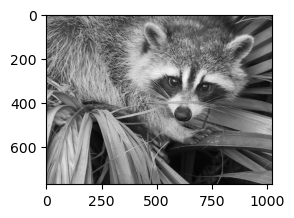

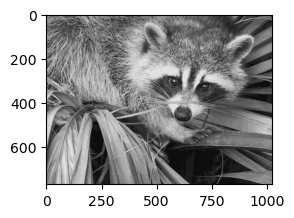

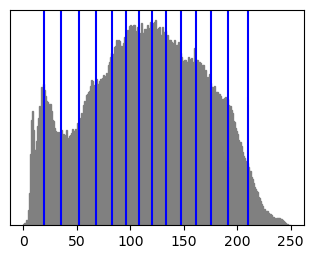

In [24]:
vmin = face.min()
vmax = face.max()

# original face
plt.figure(1, figsize=(3, 2.2))
plt.imshow(face, cmap=plt.cm.gray, vmin=vmin, vmax=256)

# compressed face
plt.figure(2, figsize=(3, 2.2))
plt.imshow(face_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)


# histogram
plt.figure(4, figsize=(3, 2.2))
plt.clf()
plt.axes([0.01, 0.01, 0.98, 0.98])
plt.hist(X, bins=256, color=".5", edgecolor=".5")
plt.yticks(())
plt.xticks()
values = np.sort(values)
for center_1, center_2 in zip(values[:-1], values[1:]):
    plt.axvline(0.5 * (center_1 + center_2), color="b")

plt.show()

**Q.** Repeat the above steps, but reduce `n_clusters` to a smaller value and comment on how the compressed image changes with each choice. Why does the image look different than when the number of clusters was 5?

### The resolution becomes lower as the n_clusters decreases.

**Q.** Repeat the above steps, but increase `n_clusters` to a value larger than 5 and comment on how the compressed image changes with each choice. Does the image look much different than when the number of clusters was 5?

### The image remains the same.

**Q.** Describe in words what is happening here. What is the k-means algorithm doing in order to generate the new image?

### The number of clusters determines how many colors there will be showing as same colors will be clustered together.

---
## Color Image Quanitization

Let's do the same as above, but on a color image instead.

In [26]:
# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow works (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255
china.shape

(427, 640, 3)

Notice the shape of the image array. This is common for color images to be a 3-dimensional array, where the first two dimensions identify the row and column (the location of the pixel) and the third dimension identifies the RGB (red, green, blue) value, which defines the color of the pixel. As before, we will need to reshape this into a 2-dimensional array to do the clustering. The new shape should be number of pixels x 3.

In [27]:
# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)

image_array = np.reshape(china, (w * h, d))
image_array.shape

(273280, 3)

We will begin by doing the clustering on just a sample of the image. Doing this will speed things up so you can iterate with a few different values for `n_colors` (which defines the number of clusters), but feel free to try larger samples if you want.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


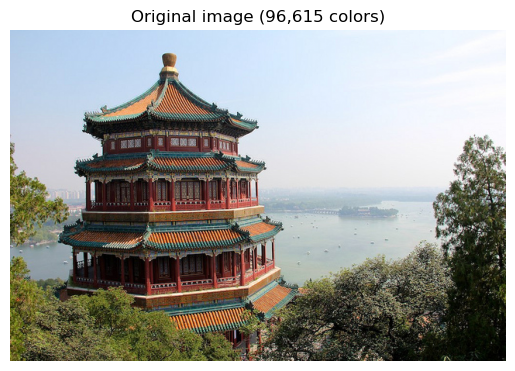

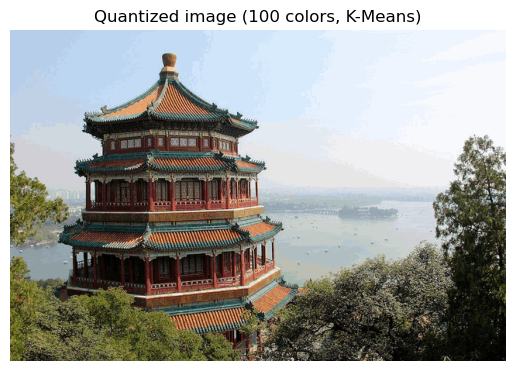

In [30]:
n_colors = 100

image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

# Get labels for all points
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

**Q.** Repeat the above using a larger number of clusters. How does the quantized image change?

### The image has more color as the number of clusters increases.

**Q.** Try larger values for the number of clusters until the quantized image looks very similar to the original image.

### About 100 colors look similar to the original image.

---
## Agglomerative Clustering

In this section we will work with agglomerative clustering, which is a type of hierarchical clustering that works from the bottom-up, meaning that all observations in $X$ start off in their own cluster, and then clusters are joined together, two clusters at a time, until there is only one cluster left. First we can define a plotting function for the dendrogram that results from the clustering algorithm.

In [31]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Now we'll load the iris dataset. For each of visualizations of the clusters we'll start with a sample of the data instead of using the entire dataset, but feel free to increase the sample, or use the whole dataset yourself.

In [32]:
# Load the iris dataset
iris = load_iris()
X, y = iris.data[0:20,], iris.target

In [33]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)

You can, if you want, look at the internal structure of the tree by looking at `model.children_` which defines how the clusters are merged together. It's a bit complex, but the way to interpret it is that you can imagine that you start with 20 clusters, so you have indexes 0-19, and for each new cluster that is formed by merging two clusters, you add an index. `model.children_` tells you which cluster indexes are merged together. If you see a number that is larger than 19 (or however many observations you have, minus 1), then these are new clusters that were formed by merging other clusters. 

For example, if you kept only the top 20 observations in the iris data, you may see that first observation at index 0 and index 17 were merged, and then index 1 and 12 were merged, and then index 4 was merged with the cluster formed by 0 and 17 (now at index 20), and then 9 is merged with the cluster formed by 1 and 12. This will be easier to see once you plot the dendrogram.

In [34]:
model.children_

array([[ 0, 17],
       [ 1, 12],
       [ 4, 20],
       [ 9, 21],
       [ 7, 22],
       [ 2,  3],
       [ 6, 11],
       [ 5, 18],
       [10, 19],
       [ 8, 13],
       [16, 28],
       [25, 26],
       [14, 15],
       [27, 30],
       [23, 31],
       [29, 34],
       [32, 33],
       [24, 35],
       [36, 37]])

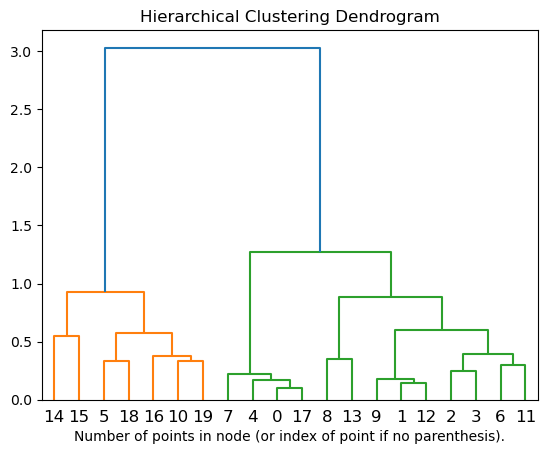

In [35]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Q.** If we decided to cut horizontally across the above dendrogram at 1.0, how many clusters would we have?

### 3 clusters.

**Q.** Approximately where should we cut the above dendrogram in order to end up with 8 clusters?

### around 0.4.

---

Feel free to change the number of levels that you plot by changing `p` to a smaller number.

Let's see what happens when we change the linkage to `single`, which you may recall joins clusters based on which two clusters have the smallest minimum distance between any pair of points in the two clusters.

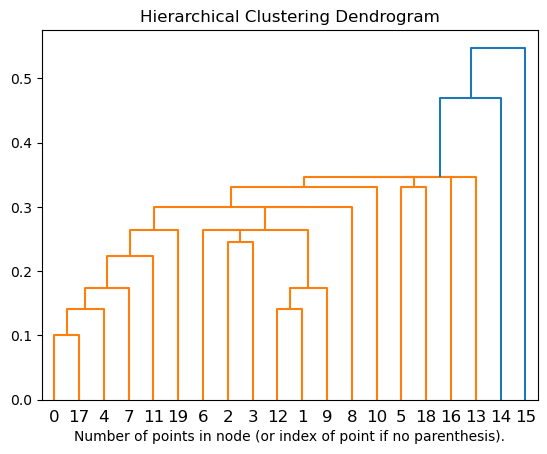

In [36]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**Q.** Look at the two dendrograms above that are obtained using different linkages. Do you notice any similarities in the clusters that are formed by the two methods?

### the lower end clusters are very similar between the two dendrograms.